Reference:
http://cs230.stanford.edu/projects_winter_2021/reports/70667451.pdf

In [93]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Flatten, AveragePooling1D, BatchNormalization, ReLU, LSTM, Bidirectional
from datetime import datetime

dataset = yf.download('TSLA', start='2022-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'),
                      progress=False,
                      period="ytd")
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.index = range(len(dataset))
dataset.head()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(
    dataset['Close'].ewm(span=10, adjust=False).mean().values.reshape(-1, 1))

#new one for training
train_size = int(len(scaled_data) * 0.8)
data_training_array = scaled_data[:train_size]
data_testing = scaled_data[train_size:]
print(data_training_array)

[[1.00000000e+00]
 [9.89148699e-01]
 [9.66980289e-01]
 [9.43778992e-01]
 [9.16636571e-01]
 [9.01166055e-01]
 [8.89866117e-01]
 [8.89662379e-01]
 [8.73353876e-01]
 [8.63913041e-01]
 [8.52059218e-01]
 [8.34823756e-01]
 [8.20856061e-01]
 [7.98105328e-01]
 [7.76485853e-01]
 [7.56289221e-01]
 [7.43874750e-01]
 [7.10300367e-01]
 [6.86559942e-01]
 [6.86674334e-01]
 [6.85585289e-01]
 [6.79161584e-01]
 [6.70766542e-01]
 [6.70855338e-01]
 [6.67473028e-01]
 [6.67875253e-01]
 [6.70366376e-01]
 [6.66469763e-01]
 [6.53649720e-01]
 [6.46567988e-01]
 [6.50864083e-01]
 [6.54586630e-01]
 [6.47462104e-01]
 [6.37445071e-01]
 [6.21584864e-01]
 [5.96178749e-01]
 [5.83333120e-01]
 [5.74790513e-01]
 [5.80894447e-01]
 [5.84578364e-01]
 [5.90947973e-01]
 [5.87381581e-01]
 [5.84247414e-01]
 [5.74394850e-01]
 [5.70618825e-01]
 [5.75003541e-01]
 [5.74122084e-01]
 [5.64114928e-01]
 [5.49661651e-01]
 [5.45515817e-01]
 [5.50413044e-01]
 [5.61202193e-01]
 [5.77335225e-01]
 [5.93944530e-01]
 [6.23277948e-01]
 [6.483871

Data from file Data&normalize

In [84]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting the dataset into train and test sets
training_size = int(len(X) * 0.67)
test_size = len(X) - training_size
X_train, X_test = X[0:training_size], X[training_size:len(X)]
Y_train, Y_test = Y[0:training_size], Y[training_size:len(Y)]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (381, 60, 1)
X_test shape:  (189, 60, 1)
Y_train shape:  (381,)
Y_test shape:  (189,)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Flatten, AveragePooling1D, BatchNormalization, ReLU

# Implementing the CNN model


def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(32, 11, activation='relu', input_shape=(time_step, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(64, 9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


cnn_model = create_cnn_model()
cnn_model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), epochs=10, batch_size=64, verbose=1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0420 - val_loss: 0.0407
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - val_loss: 0.0413
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - val_loss: 0.0407
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - val_loss: 0.0416
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.0436
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - val_loss: 0.0440
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122 - val_loss: 0.0416
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - val_loss: 0.0422
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0430
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - val_loss: 0.0427


Convert two-dimensional data into three-dimensional data

In [85]:
X_train1 = []
y_train1 = []

for i in range(100, data_training_array.shape[0]):
    X_train1.append(data_training_array[i-100:i])
    y_train1.append(data_training_array[i, 0])

X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1.shape

(404, 100, 1)

In [87]:
X_test1 = []
Y_test1 = []

for i in range (100, data_testing.shape[0]):
    X_test1.append(data_testing[i-100:i])
    Y_test1.append(data_testing[i, 0])
X_test1, Y_test1 = np.array(X_test1), np.array(Y_test1)
X_test1.shape

(27, 100, 1)

LSTM model

In [88]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train1.shape[1], 1)))
#reduce overfitting
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

X_train1 = np.asarray(X_train1)
y_train1 = np.asarray(y_train1)

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_test1, Y_test1, epochs=100, batch_size=150, verbose=2)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 2s - 2s/step - loss: 0.0593
Epoch 2/100
1/1 - 0s - 122ms/step - loss: 0.0537
Epoch 3/100
1/1 - 0s - 125ms/step - loss: 0.0475
Epoch 4/100
1/1 - 0s - 127ms/step - loss: 0.0393
Epoch 5/100
1/1 - 0s - 115ms/step - loss: 0.0323
Epoch 6/100
1/1 - 0s - 118ms/step - loss: 0.0229
Epoch 7/100
1/1 - 0s - 122ms/step - loss: 0.0111
Epoch 8/100
1/1 - 0s - 122ms/step - loss: 0.0052
Epoch 9/100
1/1 - 0s - 119ms/step - loss: 0.0062
Epoch 10/100
1/1 - 0s - 118ms/step - loss: 0.0128
Epoch 11/100
1/1 - 0s - 124ms/step - loss: 0.0158
Epoch 12/100
1/1 - 0s - 119ms/step - loss: 0.0075
Epoch 13/100
1/1 - 0s - 156ms/step - loss: 0.0046
Epoch 14/100
1/1 - 0s - 123ms/step - loss: 0.0045
Epoch 15/100
1/1 - 0s - 124ms/step - loss: 0.0061
Epoch 16/100
1/1 - 0s - 122ms/step - loss: 0.0068
Epoch 17/100
1/1 - 0s - 124ms/step - loss: 0.0056
Epoch 18/100
1/1 - 0s - 124ms/step - loss: 0.0082
Epoch 19/100
1/1 - 0s - 121ms/step - loss: 0.0076
Epoch 20/100
1/1 - 0s - 124ms/step - loss: 0.0067
Epoch 21/100
1/1 - 0s - 

In [89]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

CNN model

In [102]:
model = Sequential()
model.add(Conv1D(128, kernel_size=1, activation='relu', input_shape=(time_step, 1)))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(512, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(2))

#model.add(Flatten())
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
X_train1 = np.asarray(X_train1)
y_train1 = np.asarray(y_train1)
model.compile(optimizer='RMSProp', loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train1, y_train1, epochs=10, batch_size=150, verbose=2)
model.summary()

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 - 2s - 745ms/step - accuracy: 0.0025 - loss: 0.1039
Epoch 2/10
3/3 - 0s - 111ms/step - accuracy: 0.0025 - loss: 0.0263
Epoch 3/10
3/3 - 0s - 111ms/step - accuracy: 0.0025 - loss: 0.0285
Epoch 4/10
3/3 - 0s - 120ms/step - accuracy: 0.0025 - loss: 0.0359
Epoch 5/10
3/3 - 0s - 120ms/step - accuracy: 0.0025 - loss: 0.0216
Epoch 6/10
3/3 - 0s - 109ms/step - accuracy: 0.0025 - loss: 0.0208
Epoch 7/10
3/3 - 0s - 107ms/step - accuracy: 0.0025 - loss: 0.0209
Epoch 8/10
3/3 - 0s - 107ms/step - accuracy: 0.0025 - loss: 0.0313
Epoch 9/10
3/3 - 0s - 91ms/step - accuracy: 0.0025 - loss: 0.0205
Epoch 10/10
3/3 - 0s - 96ms/step - accuracy: 0.0025 - loss: 0.0271


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_41 (Conv1D)              │ (None, 60, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 30, 256)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 15, 512)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 7, 400)         │     1,140,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 7, 400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 400)            │       961,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,535,332 (17.30 MB)

 Trainable params: 2,267,665 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,267,667 (8.65 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


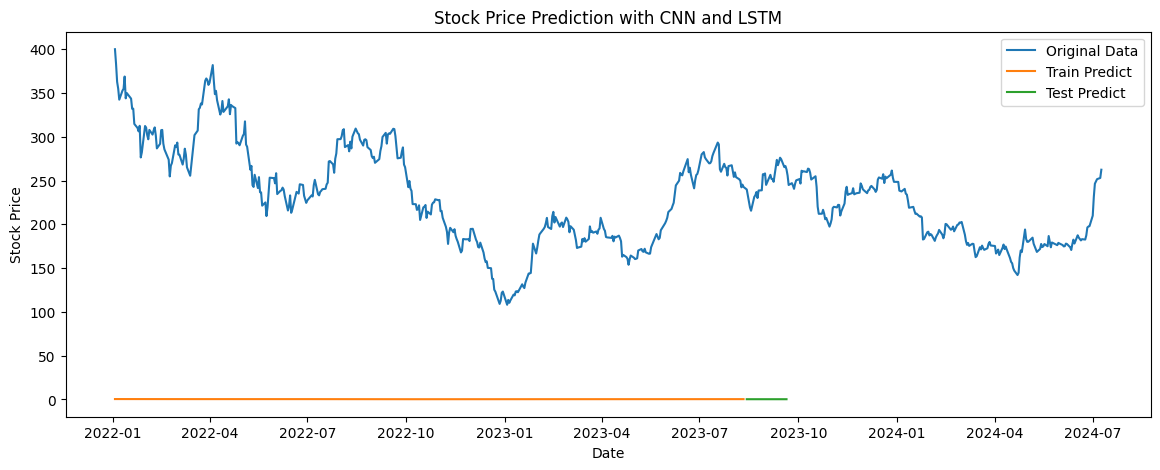

In [107]:
train_predict = model.predict(X_train1)
test_predict = model.predict(X_test1)
train_predict_df = pd.DataFrame({'Date': dataset['Date'][:len(
    train_predict)], 'Train Predict': train_predict.flatten()})
test_predict_df = pd.DataFrame({'Date': dataset['Date'][len(train_predict):(
    len(train_predict) + len(test_predict))], 'Test Predict': test_predict.flatten()})

plt.figure(figsize=(14, 5))

# Plot original data
plt.plot(dataset['Date'], dataset['Close'], label='Original Data')

# Plot train predictions
plt.plot(train_predict_df['Date'],
         train_predict_df['Train Predict'], label='Train Predict')

# Plot test predictions
plt.plot(test_predict_df['Date'],
         test_predict_df['Test Predict'], label='Test Predict')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with CNN and LSTM')
plt.legend()
plt.show()

In [53]:

from tensorflow.keras.layers import LSTM

# Implementing the LSTM model


def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.25))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(64))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_model = create_lstm_model()
lstm_model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), epochs=10, batch_size=64, verbose=1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.3752 - val_loss: 0.4688
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3796 - val_loss: 0.4688
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3689 - val_loss: 0.4688
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3745 - val_loss: 0.4688
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3623 - val_loss: 0.4688
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3734 - val_loss: 0.4688
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3737 - val_loss: 0.4688
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3703 - val_loss: 0.4688
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3830 - val_loss: 0.4688
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3686 - val_loss: 0.4688


In [54]:
cnn_predictions = cnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
cnn_predictions = scaler.inverse_transform(cnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Prepare the actual values for comparison
Y_test = Y_test.reshape(-1, 1)
Y_test = scaler.inverse_transform(Y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


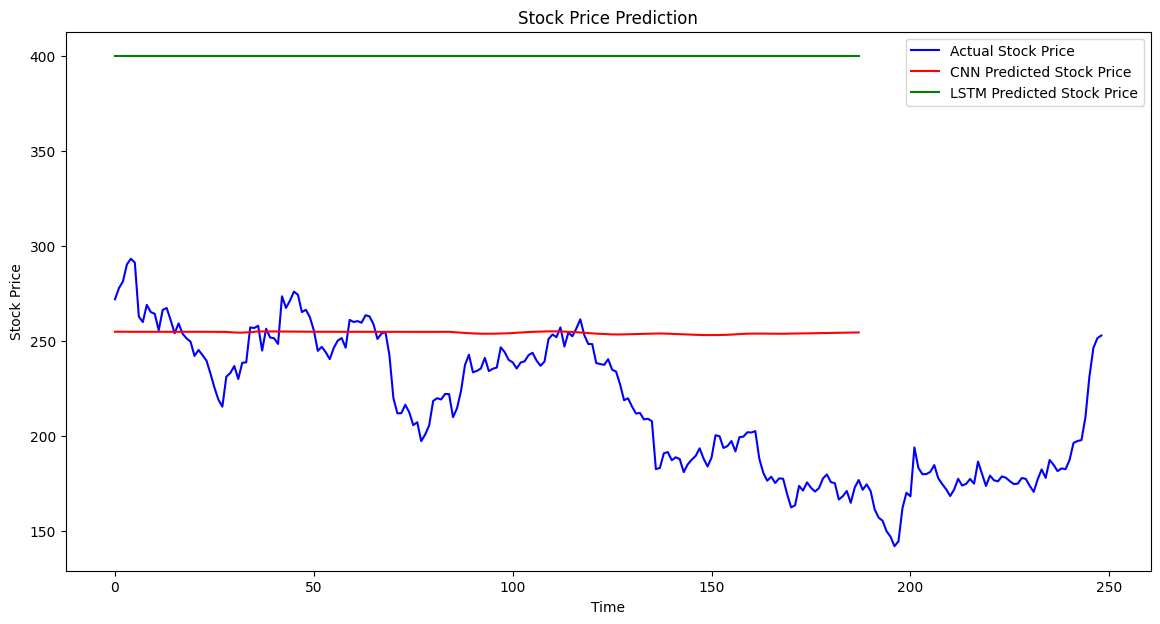

In [56]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual prices
plt.plot(scaler.inverse_transform(
    scaled_data[training_size:]), color='blue', label='Actual Stock Price')

# Plot the CNN predicted prices
plt.plot(cnn_predictions, color='red', label='CNN Predicted Stock Price')

# Plot the LSTM predicted prices
plt.plot(lstm_predictions, color='green', label='LSTM Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()